In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pysimul
from math import *

In [3]:
simul = pysimul.PySimul()
simul['T'] = T = 10
simul['gamma'] = gamma = 500
D = T / gamma
simul['part_m'] = part_m = 0.1
simul['reset_rate'] = α = 1
simul['x0sigma'] = σ = 0

In [4]:
simul.start()

In [ ]:
simul.end()

In [21]:
simul['n_trajectories']

30984

In [ ]:
simul['pause'] = 1

In [7]:
i_beg = 0

In [20]:
simul.explicit_lock()
first_times_xtarg = simul['first_times_xtarg']
for i in range(len(first_times_xtarg)):
    first_times = simul['first_times-'+str(i)]
    path = "data-poisson-fix-m0/"+str(i+i_beg)
    np.savetxt(path+"-ft.csv", first_times, fmt='%.2e')
    x_targ = first_times_xtarg[i]
    pd.DataFrame(list({
        'D': D,
        'T': T,
        'gamma': gamma,
        'part_m': part_m,
        'reset_rate': α,
        'x0sigma': σ,
        'L': x_targ,
        'b': x_targ/σ,
        'c': sqrt(α/D)*x_targ,
        'mfpt': np.mean(first_times),
        'fpt_stdev': np.std(first_times),
        'n_traj': len(first_times),
        'Delta_t': simul['Delta_t']
    }.items())).set_index(0).to_csv(path+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
simul.explicit_unlock()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


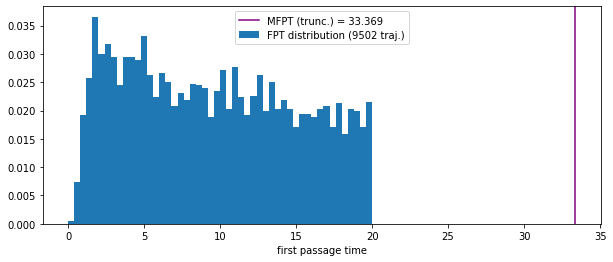

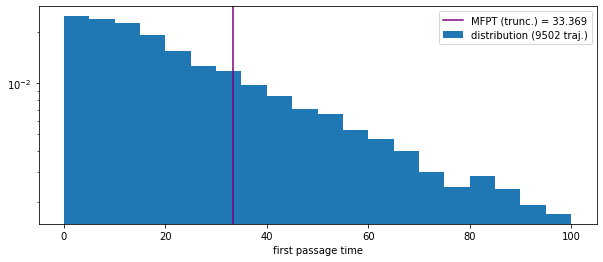

In [14]:
first_times = simul['first_times-9']
mfpt = np.mean(first_times)
n_traj = len(first_times)

plt.figure(figsize=(10,4))
plt.hist(first_times, bins=50, range=(0,20), weights=50/20*np.ones(n_traj)/n_traj, label="FPT distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT (trunc.) = {:.3f}".format(mfpt))
plt.xlabel("first passage time")
plt.legend()

plt.figure(figsize=(10,4))
plt.hist(first_times, bins=20, range=(0,100), weights=20/100*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT (trunc.) = {:.3f}".format(mfpt))
plt.yscale('log')
plt.xlabel("first passage time")
plt.legend()